In [1]:
!pip3 show tensorflow-federated

Name: tensorflow-federated
Version: 0.19.0
Summary: TensorFlow Federated is an open-source federated learning framework.
Home-page: http://tensorflow.org/federated
Author: Google Inc.
Author-email: packages@tensorflow.org
License: Apache 2.0
Location: /home/gonzaq/venv/lib/python3.6/site-packages
Requires: tensorflow-model-optimization, portpicker, cachetools, semantic-version, tensorflow-privacy, numpy, tensorflow, tqdm, retrying, jax, jaxlib, grpcio, attrs, dm-tree, absl-py
Required-by: 


In [2]:
%load_ext tensorboard

In [3]:
import nest_asyncio
nest_asyncio.apply()

In [4]:
import collections
import pickle
import matplotlib.pyplot
import numpy as np
import tensorflow as tf
import tensorflow_federated as tff

np.random.seed(0)

tff.federated_computation(lambda: 'Hello, World!')()

b'Hello, World!'

# Data exploration

In [5]:
emnist_train, emnist_test = tff.simulation.datasets.emnist.load_data()

In [6]:
NUMBER_CLIENTS = len(emnist_train.client_ids)
print('Number of clients: {} '.format(NUMBER_CLIENTS))

Number of clients: 3383 


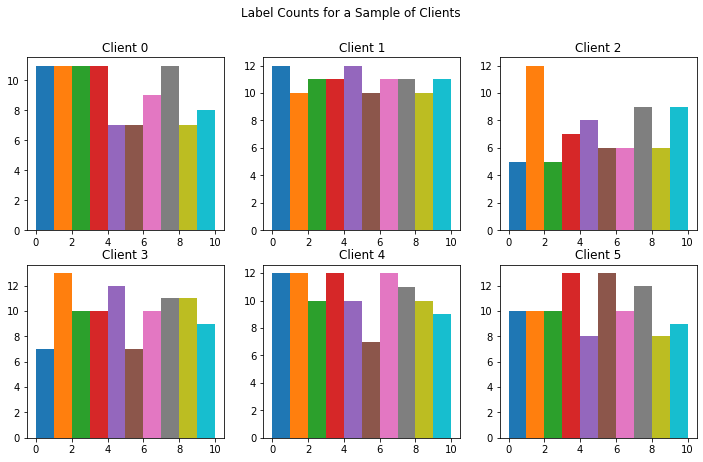

In [7]:
import matplotlib.pyplot as plt

# Number of examples per layer for a sample of clients
f = plt.figure(figsize=(12, 7))
f.suptitle('Label Counts for a Sample of Clients')
for i in range(6):
    client_dataset = emnist_train.create_tf_dataset_for_client(
      emnist_train.client_ids[i])
    plot_data = collections.defaultdict(list)
    for example in client_dataset:
        # Append counts individually per label to make plots
        # more colorful instead of one color per plot.
        label = example['label'].numpy()
        plot_data[label].append(label)
    plt.subplot(2, 3, i+1)
    plt.title('Client {}'.format(i))
    for j in range(10):
        plt.hist(
            plot_data[j],
            density=False,
            bins=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10])

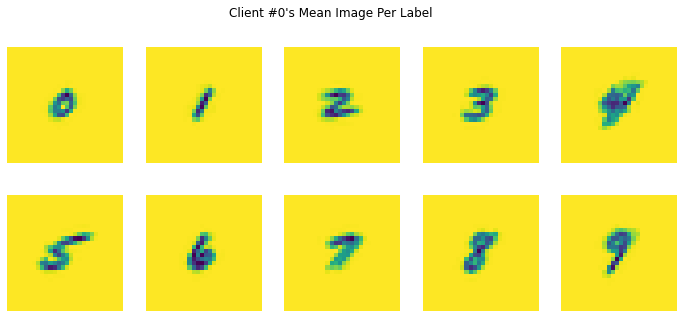

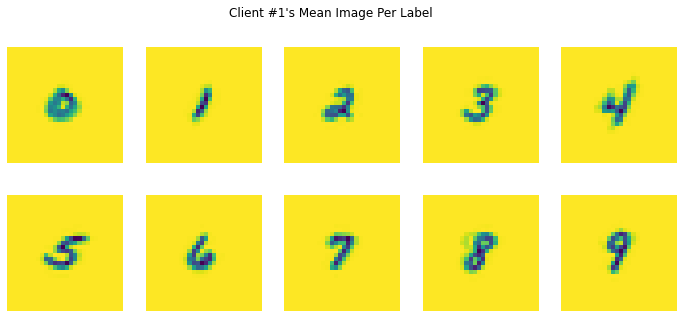

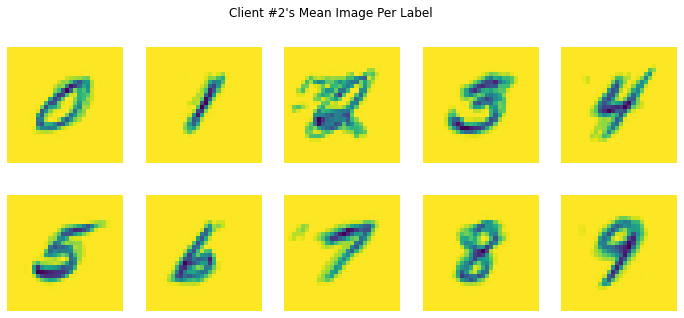

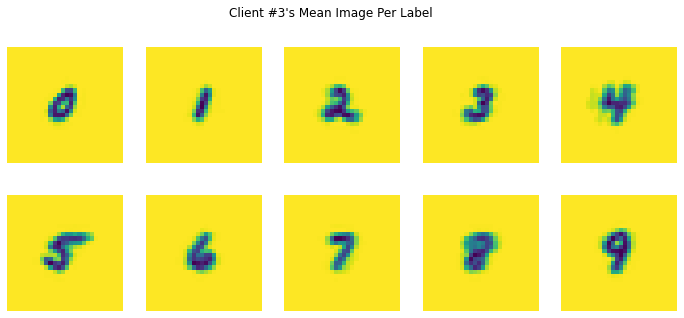

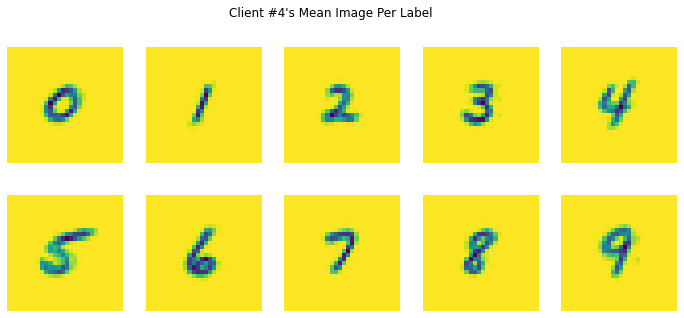

In [8]:
# Each client has different mean images, meaning each client will be nudging
# the model in their own directions locally.

for i in range(5):
  client_dataset = emnist_train.create_tf_dataset_for_client(
      emnist_train.client_ids[i])
  plot_data = collections.defaultdict(list)
  for example in client_dataset:
    plot_data[example['label'].numpy()].append(example['pixels'].numpy())
  f = plt.figure(i, figsize=(12, 5))
  f.suptitle("Client #{}'s Mean Image Per Label".format(i))
  for j in range(10):
    mean_img = np.mean(plot_data[j], 0)
    plt.subplot(2, 5, j+1)
    plt.imshow(mean_img.reshape((28, 28)))
    plt.axis('off')

# Data preprocessing

In [9]:
NUM_EPOCHS = 5
BATCH_SIZE = 20
# Number of local iterations: approx 100/20*5=5*5=25
SHUFFLE_BUFFER = 100
PREFETCH_BUFFER = 10

def preprocess(dataset):
    
    # 1) Flatten the 28x28 images into 784-element arrays
    # 2) Shuffle the individual examples
    # 3) Organize them into batches
    # 4) Rename the features from pixels and label to x and y for use with Keras
    # 5) Repeat over the data set to run several epochs

    def batch_format_fn(element):
        """Flatten a batch `pixels` and return the features as an `OrderedDict`."""
        return collections.OrderedDict(
            x=tf.reshape(element['pixels'], [-1, 784]),
            y=tf.reshape(element['label'], [-1, 1]))

    return dataset.repeat(NUM_EPOCHS).shuffle(SHUFFLE_BUFFER).batch(
      BATCH_SIZE).map(batch_format_fn).prefetch(PREFETCH_BUFFER)

In [10]:
def make_federated_data(client_data, client_ids):
    # Constructs a list of datasets, each dataset corresponding to a user
    return [
      preprocess(client_data.create_tf_dataset_for_client(x))
      for x in client_ids
    ]

### For FedSGD

In [11]:
def preprocess_fed_sgd(dataset):
    
    # 1) Flatten the 28x28 images into 784-element arrays
    # 2) Shuffle the individual examples
    # 3) Organize them into batches
    # 4) Rename the features from pixels and label to x and y for use with Keras
    # 5) Only one epoch

    def batch_format_fn(element):
        """Flatten a batch `pixels` and return the features as an `OrderedDict`."""
        return collections.OrderedDict(
            x=tf.reshape(element['pixels'], [-1, 784]),
            y=tf.reshape(element['label'], [-1, 1]))

    return dataset.repeat(1).shuffle(SHUFFLE_BUFFER).batch(
      BATCH_SIZE).map(batch_format_fn).prefetch(PREFETCH_BUFFER)

def make_federated_data_fed_sgd(client_data, client_ids):
    # Constructs a list of datasets, each dataset corresponding to a user
    return [
      preprocess(client_data.create_tf_dataset_for_client(x))
      for x in client_ids
    ]

# Create model with Keras

In [12]:
example_dataset = emnist_train.create_tf_dataset_for_client(
    emnist_train.client_ids[0])
preprocessed_example_dataset = preprocess(example_dataset)

In [13]:
def create_keras_model():
    return tf.keras.models.Sequential([
      tf.keras.layers.InputLayer(input_shape=(784,)),
      tf.keras.layers.Dense(10, kernel_initializer='zeros'),
      tf.keras.layers.Softmax(),
    ])

In [14]:
def model_fn():
    # We _must_ create a new model here, and _not_ capture it from an external
    # scope. TFF will call this within different graph contexts.
    keras_model = create_keras_model()
    return tff.learning.from_keras_model(
      keras_model,
      input_spec=preprocessed_example_dataset.element_spec,
      loss=tf.keras.losses.SparseCategoricalCrossentropy(),
      metrics=[tf.keras.metrics.SparseCategoricalAccuracy()])

# Training with FedAvg

In [15]:
# Implementation of the federated computations, the base of this implementation of FL
# In this case, we use the FedAvg algorithm
iterative_process_fed_avg = tff.learning.build_federated_averaging_process(
    model_fn,
    client_optimizer_fn=lambda: tf.keras.optimizers.SGD(learning_rate=0.02),
    server_optimizer_fn=lambda: tf.keras.optimizers.SGD(learning_rate=1.0))

evaluation = tff.learning.build_federated_evaluation(model_fn)

In [16]:
# For visualizing the training in tensorboard, we instantiate the summary writer
logdir = "/tmp/logs/scalars/training/"
summary_writer = tf.summary.create_file_writer(logdir)

In [17]:
# Start tensorboard
!ls {logdir}
%tensorboard --logdir {logdir} --port=0

events.out.tfevents.1628166498.gonzaq-Satellite-C55-C.2832.4128.v2
events.out.tfevents.1628170634.gonzaq-Satellite-C55-C.24331.4128.v2
events.out.tfevents.1628179654.gonzaq-Satellite-C55-C.12716.4128.v2


In [18]:
import random
import timeit

def add_value_to_lists_dict(_dict, key, value):
    
    if key not in _dict.keys():
        _dict[key] = [value]
    else:
        _dict[key].append(value)

def federated_training(iterative_process, num_rounds, num_clients, is_fed_sgd=False):
    
    start_time = timeit.default_timer()
        
    metrics_dict = {}
    
    # Construct the original server state
    state = iterative_process.initialize()
    with summary_writer.as_default():
        for round_num in range(2, num_rounds):

            # Randomly pick num_clients clients
            sample_clients = random.sample(emnist_train.client_ids, num_clients)

            # take the datasets of each client
            if is_fed_sgd:
                federated_train_data = make_federated_data_fed_sgd(emnist_train, sample_clients)
                federated_test_data = make_federated_data_fed_sgd(emnist_test, sample_clients)
            else:
                federated_train_data = make_federated_data(emnist_train, sample_clients)
                federated_test_data = make_federated_data(emnist_test, sample_clients)

            # FL iteration
            state, metrics = iterative_process.next(state, federated_train_data)

            metrics['test'] = evaluation(state.model, federated_train_data)

            print('round {:2d}, metrics={}'.format(round_num, metrics))

            for name, value in metrics['train'].items():
                tf.summary.scalar('train_'+name, value, step=round_num)
                add_value_to_lists_dict(metrics_dict, 'train_'+name, value)

            for name, value in metrics['test'].items():
                tf.summary.scalar('test_'+name, value, step=round_num)
                add_value_to_lists_dict(metrics_dict, 'test_'+name, value)
                
        stop_time = timeit.default_timer()
                
        return metrics_dict, stop_time - start_time


In [19]:
num_rounds_fed_avg = 200
num_clients_fed_avg = 30

In [ ]:
num_rounds_fed_avg = 200
num_clients_fed_avg = 30
metrics_fed_avg, run_time_fed_avg = federated_training(iterative_process_fed_avg, num_rounds=num_rounds_fed_avg, num_clients=num_clients_fed_avg)

In [ ]:
print('Algorithm run-time is: {} seconds'.format(run_time_fed_avg))

output_dict = metrics_fed_avg
output_dict['algorithm'] = 'FedAvg'
output_dict['num_rounds'] = num_rounds_fed_avg
output_dict['num_clients'] = num_clients_fed_avg
output_dict['run_time'] = run_time_fed_avg
output_dict['num_epochs'] = NUM_EPOCHS
output_dict['batch_size'] = BATCH_SIZE
output_dict['num_clients'] = NUMBER_CLIENTS

with open('results/fed_avg_data.p', 'wb') as fp:
    pickle.dump(output_dict, fp, protocol=pickle.HIGHEST_PROTOCOL)

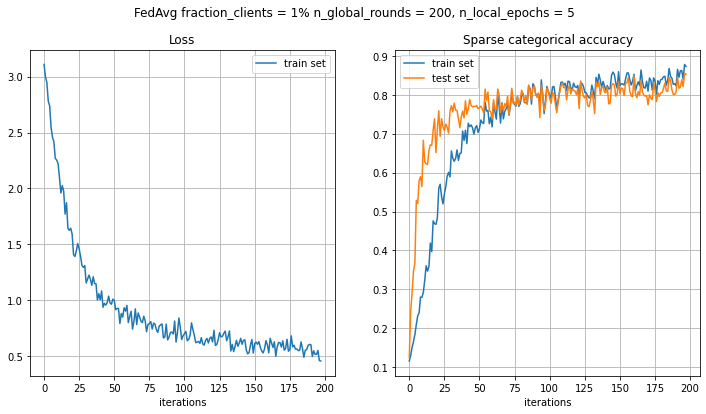

In [22]:
with open('results/fed_avg_data.p', 'rb') as fp:
    data_fed_avg = pickle.load(fp)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,6))
fig.suptitle('FedAvg fraction_clients = {}% n_global_rounds = {}, n_local_epochs = {}'.format(round(num_clients_fed_avg/NUMBER_CLIENTS*100), num_rounds_fed_avg, NUM_EPOCHS))
             
ax1.plot(data_fed_avg['train_loss'], label='train set')
ax1.set_title('Loss')
ax1.grid('on')
ax1.legend()
ax1.set_xlabel('iterations')

ax2.plot(data_fed_avg['train_sparse_categorical_accuracy'], label='train set')
ax2.plot(data_fed_avg['test_sparse_categorical_accuracy'], label='test set')
ax2.legend()
ax2.set_title('Sparse categorical accuracy')
ax2.grid('on')
ax2.set_xlabel('iterations')

plt.show()

# Training with FedSGD

In [25]:
iterative_process_fed_sgd = tff.learning.build_federated_sgd_process(
    model_fn,
    server_optimizer_fn=lambda: tf.keras.optimizers.SGD(learning_rate=0.02))

num_rounds_fed_sgd = 500
num_clients_fed_sgd = 30

metrics_fed_sgd, run_time_sgd = federated_training(iterative_process_fed_sgd, num_rounds=num_rounds_fed_sgd, num_clients=num_clients_fed_sgd, is_fed_sgd=True)

Instructions for updating:
Use `tf.compat.v1.graph_util.extract_sub_graph`


Instructions for updating:
Use `tf.compat.v1.graph_util.extract_sub_graph`


round  2, metrics=OrderedDict([('broadcast', ()), ('aggregation', OrderedDict([('mean_value', ()), ('mean_weight', ())])), ('train', OrderedDict([('sparse_categorical_accuracy', 0.096634455), ('loss', 2.3025856)])), ('stat', OrderedDict([('client_weight', 15005.0), ('has_non_finite_delta', 0)])), ('test', OrderedDict([('sparse_categorical_accuracy', 0.10663112), ('loss', 2.2981918)]))])
round  3, metrics=OrderedDict([('broadcast', ()), ('aggregation', OrderedDict([('mean_value', ()), ('mean_weight', ())])), ('train', OrderedDict([('sparse_categorical_accuracy', 0.11226141), ('loss', 2.2972326)])), ('stat', OrderedDict([('client_weight', 15455.0), ('has_non_finite_delta', 0)])), ('test', OrderedDict([('sparse_categorical_accuracy', 0.11226141), ('loss', 2.2926602)]))])
round  4, metrics=OrderedDict([('broadcast', ()), ('aggregation', OrderedDict([('mean_value', ()), ('mean_weight', ())])), ('train', OrderedDict([('sparse_categorical_accuracy', 0.10722384), ('loss', 2.2950006)])), ('stat

round 24, metrics=OrderedDict([('broadcast', ()), ('aggregation', OrderedDict([('mean_value', ()), ('mean_weight', ())])), ('train', OrderedDict([('sparse_categorical_accuracy', 0.3004695), ('loss', 2.2160497)])), ('stat', OrderedDict([('client_weight', 14910.0), ('has_non_finite_delta', 0)])), ('test', OrderedDict([('sparse_categorical_accuracy', 0.46478873), ('loss', 2.2104616)]))])
round 25, metrics=OrderedDict([('broadcast', ()), ('aggregation', OrderedDict([('mean_value', ()), ('mean_weight', ())])), ('train', OrderedDict([('sparse_categorical_accuracy', 0.42084816), ('loss', 2.2184935)])), ('stat', OrderedDict([('client_weight', 15445.0), ('has_non_finite_delta', 0)])), ('test', OrderedDict([('sparse_categorical_accuracy', 0.44350922), ('loss', 2.2143755)]))])
round 26, metrics=OrderedDict([('broadcast', ()), ('aggregation', OrderedDict([('mean_value', ()), ('mean_weight', ())])), ('train', OrderedDict([('sparse_categorical_accuracy', 0.47281554), ('loss', 2.2122507)])), ('stat',

round 46, metrics=OrderedDict([('broadcast', ()), ('aggregation', OrderedDict([('mean_value', ()), ('mean_weight', ())])), ('train', OrderedDict([('sparse_categorical_accuracy', 0.56125355), ('loss', 2.1302996)])), ('stat', OrderedDict([('client_weight', 15795.0), ('has_non_finite_delta', 0)])), ('test', OrderedDict([('sparse_categorical_accuracy', 0.6812282), ('loss', 2.1256742)]))])
round 47, metrics=OrderedDict([('broadcast', ()), ('aggregation', OrderedDict([('mean_value', ()), ('mean_weight', ())])), ('train', OrderedDict([('sparse_categorical_accuracy', 0.608365), ('loss', 2.137539)])), ('stat', OrderedDict([('client_weight', 15780.0), ('has_non_finite_delta', 0)])), ('test', OrderedDict([('sparse_categorical_accuracy', 0.45120406), ('loss', 2.1333969)]))])
round 48, metrics=OrderedDict([('broadcast', ()), ('aggregation', OrderedDict([('mean_value', ()), ('mean_weight', ())])), ('train', OrderedDict([('sparse_categorical_accuracy', 0.5350675), ('loss', 2.121688)])), ('stat', Orde

round 68, metrics=OrderedDict([('broadcast', ()), ('aggregation', OrderedDict([('mean_value', ()), ('mean_weight', ())])), ('train', OrderedDict([('sparse_categorical_accuracy', 0.5839818), ('loss', 2.0833197)])), ('stat', OrderedDict([('client_weight', 15420.0), ('has_non_finite_delta', 0)])), ('test', OrderedDict([('sparse_categorical_accuracy', 0.6199741), ('loss', 2.079049)]))])
round 69, metrics=OrderedDict([('broadcast', ()), ('aggregation', OrderedDict([('mean_value', ()), ('mean_weight', ())])), ('train', OrderedDict([('sparse_categorical_accuracy', 0.62583894), ('loss', 2.0739892)])), ('stat', OrderedDict([('client_weight', 14900.0), ('has_non_finite_delta', 0)])), ('test', OrderedDict([('sparse_categorical_accuracy', 0.5003356), ('loss', 2.0695324)]))])
round 70, metrics=OrderedDict([('broadcast', ()), ('aggregation', OrderedDict([('mean_value', ()), ('mean_weight', ())])), ('train', OrderedDict([('sparse_categorical_accuracy', 0.50733334), ('loss', 2.0684578)])), ('stat', Or

round 90, metrics=OrderedDict([('broadcast', ()), ('aggregation', OrderedDict([('mean_value', ()), ('mean_weight', ())])), ('train', OrderedDict([('sparse_categorical_accuracy', 0.688), ('loss', 1.9894582)])), ('stat', OrderedDict([('client_weight', 15625.0), ('has_non_finite_delta', 0)])), ('test', OrderedDict([('sparse_categorical_accuracy', 0.66496), ('loss', 1.984716)]))])
round 91, metrics=OrderedDict([('broadcast', ()), ('aggregation', OrderedDict([('mean_value', ()), ('mean_weight', ())])), ('train', OrderedDict([('sparse_categorical_accuracy', 0.6327759), ('loss', 1.9970077)])), ('stat', OrderedDict([('client_weight', 14950.0), ('has_non_finite_delta', 0)])), ('test', OrderedDict([('sparse_categorical_accuracy', 0.6277592), ('loss', 1.9933248)]))])
round 92, metrics=OrderedDict([('broadcast', ()), ('aggregation', OrderedDict([('mean_value', ()), ('mean_weight', ())])), ('train', OrderedDict([('sparse_categorical_accuracy', 0.65759265), ('loss', 1.9833887)])), ('stat', OrderedDi

round 112, metrics=OrderedDict([('broadcast', ()), ('aggregation', OrderedDict([('mean_value', ()), ('mean_weight', ())])), ('train', OrderedDict([('sparse_categorical_accuracy', 0.691386), ('loss', 1.9363397)])), ('stat', OrderedDict([('client_weight', 15440.0), ('has_non_finite_delta', 0)])), ('test', OrderedDict([('sparse_categorical_accuracy', 0.6674223), ('loss', 1.9330178)]))])
round 113, metrics=OrderedDict([('broadcast', ()), ('aggregation', OrderedDict([('mean_value', ()), ('mean_weight', ())])), ('train', OrderedDict([('sparse_categorical_accuracy', 0.6259417), ('loss', 1.9414262)])), ('stat', OrderedDict([('client_weight', 15265.0), ('has_non_finite_delta', 0)])), ('test', OrderedDict([('sparse_categorical_accuracy', 0.6603341), ('loss', 1.9374893)]))])
round 114, metrics=OrderedDict([('broadcast', ()), ('aggregation', OrderedDict([('mean_value', ()), ('mean_weight', ())])), ('train', OrderedDict([('sparse_categorical_accuracy', 0.68695086), ('loss', 1.9270852)])), ('stat', 

round 134, metrics=OrderedDict([('broadcast', ()), ('aggregation', OrderedDict([('mean_value', ()), ('mean_weight', ())])), ('train', OrderedDict([('sparse_categorical_accuracy', 0.7072042), ('loss', 1.8551005)])), ('stat', OrderedDict([('client_weight', 15130.0), ('has_non_finite_delta', 0)])), ('test', OrderedDict([('sparse_categorical_accuracy', 0.70423), ('loss', 1.8499062)]))])
round 135, metrics=OrderedDict([('broadcast', ()), ('aggregation', OrderedDict([('mean_value', ()), ('mean_weight', ())])), ('train', OrderedDict([('sparse_categorical_accuracy', 0.66061187), ('loss', 1.8809842)])), ('stat', OrderedDict([('client_weight', 15690.0), ('has_non_finite_delta', 0)])), ('test', OrderedDict([('sparse_categorical_accuracy', 0.73008287), ('loss', 1.8761138)]))])
round 136, metrics=OrderedDict([('broadcast', ()), ('aggregation', OrderedDict([('mean_value', ()), ('mean_weight', ())])), ('train', OrderedDict([('sparse_categorical_accuracy', 0.7183908), ('loss', 1.8735687)])), ('stat', 

round 156, metrics=OrderedDict([('broadcast', ()), ('aggregation', OrderedDict([('mean_value', ()), ('mean_weight', ())])), ('train', OrderedDict([('sparse_categorical_accuracy', 0.7001653), ('loss', 1.809871)])), ('stat', OrderedDict([('client_weight', 15125.0), ('has_non_finite_delta', 0)])), ('test', OrderedDict([('sparse_categorical_accuracy', 0.6998347), ('loss', 1.805413)]))])
round 157, metrics=OrderedDict([('broadcast', ()), ('aggregation', OrderedDict([('mean_value', ()), ('mean_weight', ())])), ('train', OrderedDict([('sparse_categorical_accuracy', 0.6640574), ('loss', 1.8179125)])), ('stat', OrderedDict([('client_weight', 15330.0), ('has_non_finite_delta', 0)])), ('test', OrderedDict([('sparse_categorical_accuracy', 0.69373775), ('loss', 1.8140391)]))])
round 158, metrics=OrderedDict([('broadcast', ()), ('aggregation', OrderedDict([('mean_value', ()), ('mean_weight', ())])), ('train', OrderedDict([('sparse_categorical_accuracy', 0.7810689), ('loss', 1.7669779)])), ('stat', O

round 178, metrics=OrderedDict([('broadcast', ()), ('aggregation', OrderedDict([('mean_value', ()), ('mean_weight', ())])), ('train', OrderedDict([('sparse_categorical_accuracy', 0.6646184), ('loss', 1.7992394)])), ('stat', OrderedDict([('client_weight', 15460.0), ('has_non_finite_delta', 0)])), ('test', OrderedDict([('sparse_categorical_accuracy', 0.66849935), ('loss', 1.796609)]))])
round 179, metrics=OrderedDict([('broadcast', ()), ('aggregation', OrderedDict([('mean_value', ()), ('mean_weight', ())])), ('train', OrderedDict([('sparse_categorical_accuracy', 0.73429143), ('loss', 1.7538071)])), ('stat', OrderedDict([('client_weight', 14960.0), ('has_non_finite_delta', 0)])), ('test', OrderedDict([('sparse_categorical_accuracy', 0.7062166), ('loss', 1.7504337)]))])
round 180, metrics=OrderedDict([('broadcast', ()), ('aggregation', OrderedDict([('mean_value', ()), ('mean_weight', ())])), ('train', OrderedDict([('sparse_categorical_accuracy', 0.7550765), ('loss', 1.7284062)])), ('stat',

round 200, metrics=OrderedDict([('broadcast', ()), ('aggregation', OrderedDict([('mean_value', ()), ('mean_weight', ())])), ('train', OrderedDict([('sparse_categorical_accuracy', 0.7365789), ('loss', 1.7094009)])), ('stat', OrderedDict([('client_weight', 14995.0), ('has_non_finite_delta', 0)])), ('test', OrderedDict([('sparse_categorical_accuracy', 0.7175725), ('loss', 1.7046378)]))])
round 201, metrics=OrderedDict([('broadcast', ()), ('aggregation', OrderedDict([('mean_value', ()), ('mean_weight', ())])), ('train', OrderedDict([('sparse_categorical_accuracy', 0.6663248), ('loss', 1.7230694)])), ('stat', OrderedDict([('client_weight', 14625.0), ('has_non_finite_delta', 0)])), ('test', OrderedDict([('sparse_categorical_accuracy', 0.6813675), ('loss', 1.719679)]))])
round 202, metrics=OrderedDict([('broadcast', ()), ('aggregation', OrderedDict([('mean_value', ()), ('mean_weight', ())])), ('train', OrderedDict([('sparse_categorical_accuracy', 0.7227139), ('loss', 1.728267)])), ('stat', Or

round 222, metrics=OrderedDict([('broadcast', ()), ('aggregation', OrderedDict([('mean_value', ()), ('mean_weight', ())])), ('train', OrderedDict([('sparse_categorical_accuracy', 0.6849406), ('loss', 1.6958143)])), ('stat', OrderedDict([('client_weight', 15140.0), ('has_non_finite_delta', 0)])), ('test', OrderedDict([('sparse_categorical_accuracy', 0.7123514), ('loss', 1.6921417)]))])
round 223, metrics=OrderedDict([('broadcast', ()), ('aggregation', OrderedDict([('mean_value', ()), ('mean_weight', ())])), ('train', OrderedDict([('sparse_categorical_accuracy', 0.73589396), ('loss', 1.6598005)])), ('stat', OrderedDict([('client_weight', 14710.0), ('has_non_finite_delta', 0)])), ('test', OrderedDict([('sparse_categorical_accuracy', 0.7134602), ('loss', 1.6552868)]))])
round 224, metrics=OrderedDict([('broadcast', ()), ('aggregation', OrderedDict([('mean_value', ()), ('mean_weight', ())])), ('train', OrderedDict([('sparse_categorical_accuracy', 0.6306744), ('loss', 1.7172874)])), ('stat',

round 244, metrics=OrderedDict([('broadcast', ()), ('aggregation', OrderedDict([('mean_value', ()), ('mean_weight', ())])), ('train', OrderedDict([('sparse_categorical_accuracy', 0.7258786), ('loss', 1.6364862)])), ('stat', OrderedDict([('client_weight', 15650.0), ('has_non_finite_delta', 0)])), ('test', OrderedDict([('sparse_categorical_accuracy', 0.7233227), ('loss', 1.6337484)]))])
round 245, metrics=OrderedDict([('broadcast', ()), ('aggregation', OrderedDict([('mean_value', ()), ('mean_weight', ())])), ('train', OrderedDict([('sparse_categorical_accuracy', 0.7215406), ('loss', 1.6502253)])), ('stat', OrderedDict([('client_weight', 14670.0), ('has_non_finite_delta', 0)])), ('test', OrderedDict([('sparse_categorical_accuracy', 0.740968), ('loss', 1.6467038)]))])
round 246, metrics=OrderedDict([('broadcast', ()), ('aggregation', OrderedDict([('mean_value', ()), ('mean_weight', ())])), ('train', OrderedDict([('sparse_categorical_accuracy', 0.7341983), ('loss', 1.6026008)])), ('stat', O

round 266, metrics=OrderedDict([('broadcast', ()), ('aggregation', OrderedDict([('mean_value', ()), ('mean_weight', ())])), ('train', OrderedDict([('sparse_categorical_accuracy', 0.74863386), ('loss', 1.5651048)])), ('stat', OrderedDict([('client_weight', 14640.0), ('has_non_finite_delta', 0)])), ('test', OrderedDict([('sparse_categorical_accuracy', 0.7291667), ('loss', 1.5599196)]))])
round 267, metrics=OrderedDict([('broadcast', ()), ('aggregation', OrderedDict([('mean_value', ()), ('mean_weight', ())])), ('train', OrderedDict([('sparse_categorical_accuracy', 0.66558653), ('loss', 1.6336694)])), ('stat', OrderedDict([('client_weight', 15430.0), ('has_non_finite_delta', 0)])), ('test', OrderedDict([('sparse_categorical_accuracy', 0.70933247), ('loss', 1.6281712)]))])
round 268, metrics=OrderedDict([('broadcast', ()), ('aggregation', OrderedDict([('mean_value', ()), ('mean_weight', ())])), ('train', OrderedDict([('sparse_categorical_accuracy', 0.6992238), ('loss', 1.6346474)])), ('stat

round 288, metrics=OrderedDict([('broadcast', ()), ('aggregation', OrderedDict([('mean_value', ()), ('mean_weight', ())])), ('train', OrderedDict([('sparse_categorical_accuracy', 0.7357616), ('loss', 1.5542827)])), ('stat', OrderedDict([('client_weight', 15100.0), ('has_non_finite_delta', 0)])), ('test', OrderedDict([('sparse_categorical_accuracy', 0.72781456), ('loss', 1.550882)]))])
round 289, metrics=OrderedDict([('broadcast', ()), ('aggregation', OrderedDict([('mean_value', ()), ('mean_weight', ())])), ('train', OrderedDict([('sparse_categorical_accuracy', 0.7839245), ('loss', 1.4947796)])), ('stat', OrderedDict([('client_weight', 15365.0), ('has_non_finite_delta', 0)])), ('test', OrderedDict([('sparse_categorical_accuracy', 0.7728604), ('loss', 1.4908172)]))])
round 290, metrics=OrderedDict([('broadcast', ()), ('aggregation', OrderedDict([('mean_value', ()), ('mean_weight', ())])), ('train', OrderedDict([('sparse_categorical_accuracy', 0.70656884), ('loss', 1.5759352)])), ('stat',

round 310, metrics=OrderedDict([('broadcast', ()), ('aggregation', OrderedDict([('mean_value', ()), ('mean_weight', ())])), ('train', OrderedDict([('sparse_categorical_accuracy', 0.70901084), ('loss', 1.5595894)])), ('stat', OrderedDict([('client_weight', 14760.0), ('has_non_finite_delta', 0)])), ('test', OrderedDict([('sparse_categorical_accuracy', 0.703252), ('loss', 1.5572441)]))])
round 311, metrics=OrderedDict([('broadcast', ()), ('aggregation', OrderedDict([('mean_value', ()), ('mean_weight', ())])), ('train', OrderedDict([('sparse_categorical_accuracy', 0.6941252), ('loss', 1.5587413)])), ('stat', OrderedDict([('client_weight', 15660.0), ('has_non_finite_delta', 0)])), ('test', OrderedDict([('sparse_categorical_accuracy', 0.72573435), ('loss', 1.5563387)]))])
round 312, metrics=OrderedDict([('broadcast', ()), ('aggregation', OrderedDict([('mean_value', ()), ('mean_weight', ())])), ('train', OrderedDict([('sparse_categorical_accuracy', 0.7790108), ('loss', 1.482489)])), ('stat', 

round 332, metrics=OrderedDict([('broadcast', ()), ('aggregation', OrderedDict([('mean_value', ()), ('mean_weight', ())])), ('train', OrderedDict([('sparse_categorical_accuracy', 0.6695393), ('loss', 1.525185)])), ('stat', OrderedDict([('client_weight', 15085.0), ('has_non_finite_delta', 0)])), ('test', OrderedDict([('sparse_categorical_accuracy', 0.7292012), ('loss', 1.5154377)]))])
round 333, metrics=OrderedDict([('broadcast', ()), ('aggregation', OrderedDict([('mean_value', ()), ('mean_weight', ())])), ('train', OrderedDict([('sparse_categorical_accuracy', 0.71596247), ('loss', 1.5173554)])), ('stat', OrderedDict([('client_weight', 14910.0), ('has_non_finite_delta', 0)])), ('test', OrderedDict([('sparse_categorical_accuracy', 0.71227366), ('loss', 1.5120145)]))])
round 334, metrics=OrderedDict([('broadcast', ()), ('aggregation', OrderedDict([('mean_value', ()), ('mean_weight', ())])), ('train', OrderedDict([('sparse_categorical_accuracy', 0.7308176), ('loss', 1.4989234)])), ('stat',

round 354, metrics=OrderedDict([('broadcast', ()), ('aggregation', OrderedDict([('mean_value', ()), ('mean_weight', ())])), ('train', OrderedDict([('sparse_categorical_accuracy', 0.7268752), ('loss', 1.443952)])), ('stat', OrderedDict([('client_weight', 14865.0), ('has_non_finite_delta', 0)])), ('test', OrderedDict([('sparse_categorical_accuracy', 0.7662294), ('loss', 1.4382089)]))])
round 355, metrics=OrderedDict([('broadcast', ()), ('aggregation', OrderedDict([('mean_value', ()), ('mean_weight', ())])), ('train', OrderedDict([('sparse_categorical_accuracy', 0.73722625), ('loss', 1.457614)])), ('stat', OrderedDict([('client_weight', 15070.0), ('has_non_finite_delta', 0)])), ('test', OrderedDict([('sparse_categorical_accuracy', 0.7229595), ('loss', 1.4538661)]))])
round 356, metrics=OrderedDict([('broadcast', ()), ('aggregation', OrderedDict([('mean_value', ()), ('mean_weight', ())])), ('train', OrderedDict([('sparse_categorical_accuracy', 0.72598684), ('loss', 1.4546771)])), ('stat', 

round 376, metrics=OrderedDict([('broadcast', ()), ('aggregation', OrderedDict([('mean_value', ()), ('mean_weight', ())])), ('train', OrderedDict([('sparse_categorical_accuracy', 0.75356215), ('loss', 1.4090466)])), ('stat', OrderedDict([('client_weight', 15440.0), ('has_non_finite_delta', 0)])), ('test', OrderedDict([('sparse_categorical_accuracy', 0.74740934), ('loss', 1.4034424)]))])
round 377, metrics=OrderedDict([('broadcast', ()), ('aggregation', OrderedDict([('mean_value', ()), ('mean_weight', ())])), ('train', OrderedDict([('sparse_categorical_accuracy', 0.7546224), ('loss', 1.3999771)])), ('stat', OrderedDict([('client_weight', 15955.0), ('has_non_finite_delta', 0)])), ('test', OrderedDict([('sparse_categorical_accuracy', 0.76089), ('loss', 1.3972493)]))])
round 378, metrics=OrderedDict([('broadcast', ()), ('aggregation', OrderedDict([('mean_value', ()), ('mean_weight', ())])), ('train', OrderedDict([('sparse_categorical_accuracy', 0.7633758), ('loss', 1.3857554)])), ('stat', 

round 398, metrics=OrderedDict([('broadcast', ()), ('aggregation', OrderedDict([('mean_value', ()), ('mean_weight', ())])), ('train', OrderedDict([('sparse_categorical_accuracy', 0.76673496), ('loss', 1.3807575)])), ('stat', OrderedDict([('client_weight', 14640.0), ('has_non_finite_delta', 0)])), ('test', OrderedDict([('sparse_categorical_accuracy', 0.74931693), ('loss', 1.3758421)]))])
round 399, metrics=OrderedDict([('broadcast', ()), ('aggregation', OrderedDict([('mean_value', ()), ('mean_weight', ())])), ('train', OrderedDict([('sparse_categorical_accuracy', 0.759824), ('loss', 1.3387971)])), ('stat', OrderedDict([('client_weight', 15905.0), ('has_non_finite_delta', 0)])), ('test', OrderedDict([('sparse_categorical_accuracy', 0.7692549), ('loss', 1.3352047)]))])
round 400, metrics=OrderedDict([('broadcast', ()), ('aggregation', OrderedDict([('mean_value', ()), ('mean_weight', ())])), ('train', OrderedDict([('sparse_categorical_accuracy', 0.75479674), ('loss', 1.3853576)])), ('stat'

round 420, metrics=OrderedDict([('broadcast', ()), ('aggregation', OrderedDict([('mean_value', ()), ('mean_weight', ())])), ('train', OrderedDict([('sparse_categorical_accuracy', 0.77433914), ('loss', 1.3198459)])), ('stat', OrderedDict([('client_weight', 15510.0), ('has_non_finite_delta', 0)])), ('test', OrderedDict([('sparse_categorical_accuracy', 0.7769181), ('loss', 1.315032)]))])
round 421, metrics=OrderedDict([('broadcast', ()), ('aggregation', OrderedDict([('mean_value', ()), ('mean_weight', ())])), ('train', OrderedDict([('sparse_categorical_accuracy', 0.6699712), ('loss', 1.4630674)])), ('stat', OrderedDict([('client_weight', 15635.0), ('has_non_finite_delta', 0)])), ('test', OrderedDict([('sparse_categorical_accuracy', 0.71346337), ('loss', 1.4564888)]))])
round 422, metrics=OrderedDict([('broadcast', ()), ('aggregation', OrderedDict([('mean_value', ()), ('mean_weight', ())])), ('train', OrderedDict([('sparse_categorical_accuracy', 0.75208336), ('loss', 1.3945549)])), ('stat'

round 442, metrics=OrderedDict([('broadcast', ()), ('aggregation', OrderedDict([('mean_value', ()), ('mean_weight', ())])), ('train', OrderedDict([('sparse_categorical_accuracy', 0.7402012), ('loss', 1.3578573)])), ('stat', OrderedDict([('client_weight', 14415.0), ('has_non_finite_delta', 0)])), ('test', OrderedDict([('sparse_categorical_accuracy', 0.72979534), ('loss', 1.3537577)]))])
round 443, metrics=OrderedDict([('broadcast', ()), ('aggregation', OrderedDict([('mean_value', ()), ('mean_weight', ())])), ('train', OrderedDict([('sparse_categorical_accuracy', 0.75033647), ('loss', 1.3167241)])), ('stat', OrderedDict([('client_weight', 14860.0), ('has_non_finite_delta', 0)])), ('test', OrderedDict([('sparse_categorical_accuracy', 0.7681696), ('loss', 1.3129054)]))])
round 444, metrics=OrderedDict([('broadcast', ()), ('aggregation', OrderedDict([('mean_value', ()), ('mean_weight', ())])), ('train', OrderedDict([('sparse_categorical_accuracy', 0.7432083), ('loss', 1.3378639)])), ('stat'

round 464, metrics=OrderedDict([('broadcast', ()), ('aggregation', OrderedDict([('mean_value', ()), ('mean_weight', ())])), ('train', OrderedDict([('sparse_categorical_accuracy', 0.7628041), ('loss', 1.3307098)])), ('stat', OrderedDict([('client_weight', 15620.0), ('has_non_finite_delta', 0)])), ('test', OrderedDict([('sparse_categorical_accuracy', 0.7682458), ('loss', 1.3275883)]))])
round 465, metrics=OrderedDict([('broadcast', ()), ('aggregation', OrderedDict([('mean_value', ()), ('mean_weight', ())])), ('train', OrderedDict([('sparse_categorical_accuracy', 0.7712294), ('loss', 1.3014235)])), ('stat', OrderedDict([('client_weight', 15780.0), ('has_non_finite_delta', 0)])), ('test', OrderedDict([('sparse_categorical_accuracy', 0.7728137), ('loss', 1.298035)]))])
round 466, metrics=OrderedDict([('broadcast', ()), ('aggregation', OrderedDict([('mean_value', ()), ('mean_weight', ())])), ('train', OrderedDict([('sparse_categorical_accuracy', 0.7735028), ('loss', 1.3058857)])), ('stat', O

round 486, metrics=OrderedDict([('broadcast', ()), ('aggregation', OrderedDict([('mean_value', ()), ('mean_weight', ())])), ('train', OrderedDict([('sparse_categorical_accuracy', 0.7967125), ('loss', 1.2298359)])), ('stat', OrderedDict([('client_weight', 14905.0), ('has_non_finite_delta', 0)])), ('test', OrderedDict([('sparse_categorical_accuracy', 0.7869842), ('loss', 1.2256352)]))])
round 487, metrics=OrderedDict([('broadcast', ()), ('aggregation', OrderedDict([('mean_value', ()), ('mean_weight', ())])), ('train', OrderedDict([('sparse_categorical_accuracy', 0.73476005), ('loss', 1.3161272)])), ('stat', OrderedDict([('client_weight', 15420.0), ('has_non_finite_delta', 0)])), ('test', OrderedDict([('sparse_categorical_accuracy', 0.7577821), ('loss', 1.3107493)]))])
round 488, metrics=OrderedDict([('broadcast', ()), ('aggregation', OrderedDict([('mean_value', ()), ('mean_weight', ())])), ('train', OrderedDict([('sparse_categorical_accuracy', 0.79753006), ('loss', 1.2598366)])), ('stat'

In [28]:
import pickle
# save model
output_dict = metrics_fed_sgd
output_dict['algorithm'] = 'FedSGD'
output_dict['num_rounds'] = num_rounds_fed_sgd
output_dict['num_clients'] = num_clients_fed_sgd
output_dict['run_time'] = run_time_sgd
output_dict['num_epochs'] = NUM_EPOCHS
output_dict['batch_size'] = BATCH_SIZE
output_dict['num_clients'] = NUMBER_CLIENTS
with open('results/fed_sgd_500it_data.p', 'wb') as fp:
    pickle.dump(output_dict, fp, protocol=pickle.HIGHEST_PROTOCOL)
    
print('Algorithm run-time is: {} seconds'.format(round(run_time_sgd)))

Algorithm run-time is: 4459 seconds


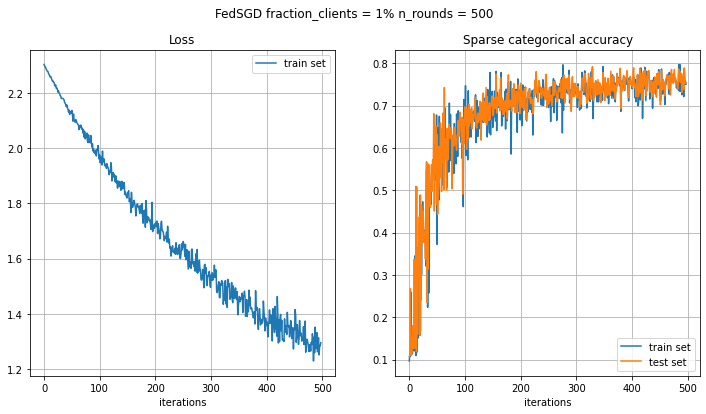

In [31]:
with open('results/fed_sgd_500it_data.p', 'rb') as fp:
    data_fed_sgd = pickle.load(fp)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,6))
fig.suptitle('FedSGD fraction_clients = {}% n_rounds = {}'.format(round(num_clients_fed_sgd/NUMBER_CLIENTS*100), num_rounds_fed_sgd))
             
ax1.plot(data_fed_sgd['train_loss'], label='train set')
ax1.set_title('Loss')
ax1.grid('on')
ax1.legend()
ax1.set_xlabel('iterations')

ax2.plot(data_fed_sgd['train_sparse_categorical_accuracy'], label='train set')
ax2.plot(data_fed_sgd['test_sparse_categorical_accuracy'], label='test set')
ax2.legend()
ax2.set_title('Sparse categorical accuracy')
ax2.grid('on')
ax2.set_xlabel('iterations')

plt.show()

# Training with FedProx 

Need to implement the algorithm, as it is not implemented natively in TensorFlow Federated

## 1 - Initialization computation

In [74]:
@tff.tf_computation
def server_init():
    model = model_fn()
    return model.trainable_variables

@tff.federated_computation
def initialize_fn():
    return tff.federated_value(server_init(), tff.SERVER)

## 2 - FL iterations

### Updates in the clients' side

In [75]:
def difference_model_norm_2_square(global_model, local_model):
    """Calculates the squared l2 norm of a model difference (i.e.
    local_model - global_model)
    Args:
        global_model: the model broadcast by the server
        local_model: the current, in-training model

    Returns: the squared norm

    """
    model_difference = tf.nest.map_structure(lambda a, b: a - b,
                                           local_model,
                                           global_model)
    squared_norm = tf.square(tf.linalg.global_norm(model_difference))
    return squared_norm

@tf.function
def client_update(model, dataset, server_weights, client_optimizer):
    """Performs training (using the server model weights) on the client's dataset."""
    # Initialize the client model with the current server weights.
    client_weights = model.trainable_variables
    # Assign the server weights to the client model.
    tf.nest.map_structure(lambda x, y: x.assign(y),
                        client_weights, server_weights)

    # Use the client_optimizer to update the local model.
    for batch in dataset:
        with tf.GradientTape() as tape:
            # Compute a forward pass on the batch of data
            outputs = model.forward_pass(batch)
            
            # Add the proximal term
            mu = tf.constant(0.2, dtype=tf.float32)
            prox_term =(mu/2)*difference_model_norm_2_square(client_weights, server_weights)
            
            # Final loss
            fedprox_loss = outputs.loss + prox_term

        # Compute the corresponding gradient
        grads = tape.gradient(fedprox_loss, client_weights)
        grads_and_vars = zip(grads, client_weights)

        # Apply the gradient using a client optimizer.
        client_optimizer.apply_gradients(grads_and_vars)

    return client_weights

### Updates on the server's side

In [76]:
@tf.function
def server_update(model, mean_client_weights):
    """Updates the server model weights as the average of the client model weights."""
    model_weights = model.trainable_variables
    # Assign the mean client weights to the server model.
    tf.nest.map_structure(lambda x, y: x.assign(y),
                        model_weights, mean_client_weights)
    return model_weights

### Create tff.tf_computation for the clients' and server's updates

In [77]:
whimsy_model = model_fn()
tf_dataset_type = tff.SequenceType(whimsy_model.input_spec)

model_weights_type = server_init.type_signature.result

@tff.tf_computation(tf_dataset_type, model_weights_type)
def client_update_fn(tf_dataset, server_weights):
    model = model_fn()
    client_optimizer = tf.keras.optimizers.SGD(learning_rate=0.02)
    return client_update(model, tf_dataset, server_weights, client_optimizer)

@tff.tf_computation(model_weights_type)
def server_update_fn(mean_client_weights):
    model = model_fn()
    return server_update(model, mean_client_weights)

In [78]:
federated_server_type = tff.FederatedType(model_weights_type, tff.SERVER)
federated_dataset_type = tff.FederatedType(tf_dataset_type, tff.CLIENTS)

In [79]:
@tff.federated_computation(federated_server_type, federated_dataset_type)
def next_fn(server_weights, federated_dataset):
    # Broadcast the server weights to the clients.
    server_weights_at_client = tff.federated_broadcast(server_weights)

    # Each client computes their updated weights.
    client_weights = tff.federated_map(
      client_update_fn, (federated_dataset, server_weights_at_client))

    # The server averages these updates.
    mean_client_weights = tff.federated_mean(client_weights)

    # The server updates its model.
    server_weights = tff.federated_map(server_update_fn, mean_client_weights)

    return server_weights

### Construct the iterative process

In [80]:
iterative_process_fed_prox = tff.templates.IterativeProcess(
    initialize_fn=initialize_fn,
    next_fn=next_fn
)

We have a look at the signatures

In [81]:
print(str(federated_algorithm.initialize.type_signature))
print(str(federated_algorithm.next.type_signature))

( -> <float32[784,10],float32[10]>@SERVER)
(<server_weights=<float32[784,10],float32[10]>@SERVER,federated_dataset={<x=float32[?,784],y=int32[?,1]>*}@CLIENTS> -> <float32[784,10],float32[10]>@SERVER)


### Train with FedProx

In [72]:
num_rounds_fed_prox = 200
num_clients_fed_prox = 30

metrics_fed_prox, run_time_prox = federated_training(iterative_process_fed_prox, num_rounds=num_rounds_fed_prox, num_clients=num_clients_fed_prox)

Instructions for updating:
Use `tf.compat.v1.graph_util.extract_sub_graph`


Instructions for updating:
Use `tf.compat.v1.graph_util.extract_sub_graph`


AttributeError: 'numpy.ndarray' object has no attribute 'model'

# Comparisons of the algorithms

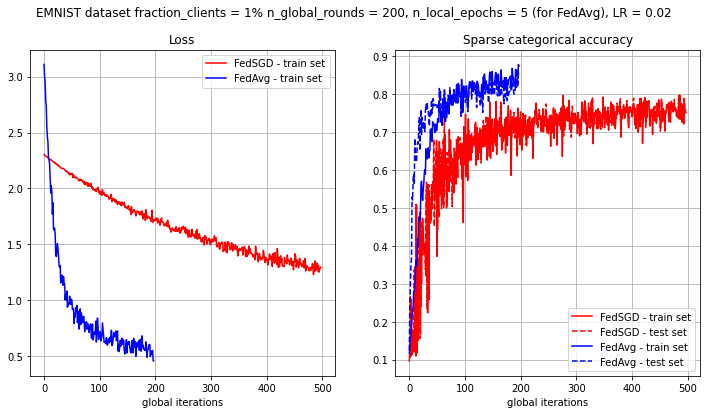

In [32]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,6))
fig.suptitle('EMNIST dataset fraction_clients = {}% n_global_rounds = {}, n_local_epochs = {} (for FedAvg), LR = {}'
             .format(round(num_clients_fed_avg/NUMBER_CLIENTS*100), num_rounds_fed_avg, NUM_EPOCHS, 0.02))
             
ax1.plot(data_fed_sgd['train_loss'], '-r', label='FedSGD - train set')
ax1.plot(data_fed_avg['train_loss'], '-b', label='FedAvg - train set')
ax1.set_title('Loss')
ax1.grid('on')
ax1.legend()
ax1.set_xlabel('global iterations')

ax2.plot(data_fed_sgd['train_sparse_categorical_accuracy'], '-r', label='FedSGD - train set')
ax2.plot(data_fed_sgd['test_sparse_categorical_accuracy'], '--r', label='FedSGD - test set')
ax2.plot(data_fed_avg['train_sparse_categorical_accuracy'], '-b', label='FedAvg - train set')
ax2.plot(data_fed_avg['test_sparse_categorical_accuracy'], '--b', label='FedAvg - test set')
ax2.legend()
ax2.set_title('Sparse categorical accuracy')
ax2.grid('on')
ax2.set_xlabel('global iterations')

plt.show()